In [1]:
import pandas as pd
from potnet import *

2025-04-17 12:22:20.483736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744917740.504916   70991 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744917740.511539   70991 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744917740.527922   70991 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744917740.527939   70991 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744917740.527941   70991 computation_placer.cc:177] computation placer alr

In [2]:
high_model = load_model('hf_potnet_model_v3.pt')
mid_model = load_model('hf_potnet_mid.pt')
low_model = load_model('hf_potnet_model_low.pt')

Model loaded from hf_potnet_model_v3.pt
Model loaded from hf_potnet_mid.pt
Model loaded from hf_potnet_model_low.pt


In [5]:
mid_rows = 271634 - 37247
high_rows = 271634 - 15166
only_high_data = high_model.generate(high_rows)
only_mid_data = mid_model.generate(mid_rows)

In [6]:
only_high_data.downloads_category.value_counts()

downloads_category
High    256468
Name: count, dtype: int64

In [7]:
only_mid_data.downloads_category.value_counts()

downloads_category
Mid    234387
Name: count, dtype: int64

In [3]:
df = pd.read_csv('data/hf_models_withmodelcard_nov2024.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191759 entries, 0 to 1191758
Data columns (total 25 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   model_id             1191759 non-null  object
 1   num_downloads        1191759 non-null  int64 
 2   num_likes            1191759 non-null  int64 
 3   is_private           1191759 non-null  bool  
 4   task                 1191759 non-null  object
 5   tags                 1191759 non-null  object
 6   author               1191759 non-null  object
 7   author_category      1191759 non-null  object
 8   base_model_relation  322 non-null      object
 9   base_model           269144 non-null   object
 10  language             1191759 non-null  object
 11  model_creator        6528 non-null     object
 12  model_type           4578 non-null     object
 13  model_name           6433 non-null     object
 14  model_card_tags      376770 non-null   object
 15  datasets       

In [7]:
import ast
df['tags'] = df['tags'].apply(ast.literal_eval)
df['location'] = df['tags'].apply(
    lambda tags: next((tag.split(':', 1)[1] for tag in tags if tag.startswith('region:')), None)
)

In [9]:
df = df[['task_group', 'author_category', 'language_category', 'downloads_category', 'location']]
df.downloads_category.value_counts()

downloads_category
Very Low    867712
Low         271634
Mid          37247
High         15166
Name: count, dtype: int64

In [10]:
combined_data = pd.concat([only_mid_data, only_high_data], ignore_index=True)
combined_data.downloads_category.value_counts()

downloads_category
High    256468
Mid     234387
Name: count, dtype: int64

In [11]:
combined_data_v2 = pd.concat([df, combined_data], ignore_index=True)
combined_data_v2.downloads_category.value_counts()

downloads_category
Very Low    867712
Low         271634
High        271634
Mid         271634
Name: count, dtype: int64

In [12]:
combined_data_v2.to_csv('data/generated_data/hf_11_24_generated.csv', index=False)

# Stratified sampling

Remove rows from Very Low (apply stratified sampling, and try to keep equal no. of samples for each task group where downloads category is very low)

In [11]:
# Determine the minimum count across downloads_category buckets
min_count = combined_data_v2['downloads_category'].value_counts().min()
print("Minimum count for downloads_category:", min_count)

def stratified_sampling_within_category(group, target):
    # Get unique task groups in this downloads_category
    unique_tasks = group['task_group'].unique()
    n_tasks = len(unique_tasks)
    # Determine target sample size per task_group (using integer division)
    sample_per_task = target // n_tasks
    sampled_frames = []
    for task in unique_tasks:
        sub_df = group[group['task_group'] == task]
        # If sub_df has fewer rows than sample_per_task, sample with replacement; otherwise without
        if len(sub_df) < sample_per_task:
            sampled = sub_df.sample(n=sample_per_task, replace=True, random_state=42)
        else:
            sampled = sub_df.sample(n=sample_per_task, random_state=42)
        sampled_frames.append(sampled)
    # Combine the samples from all task groups within this downloads_category
    return pd.concat(sampled_frames)

# Apply stratified sampling per downloads_category group
sampled_df = combined_data_v2.groupby('downloads_category', group_keys=False).apply(lambda g: stratified_sampling_within_category(g, min_count))

print("Sample counts by downloads_category:")
print(sampled_df['downloads_category'].value_counts())

print("Within each downloads_category, task_group counts:")
print(sampled_df.groupby('downloads_category')['task_group'].value_counts())

Minimum count for downloads_category: 271634


/tmp/ipykernel_449832/929817354.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = combined_data_v2.groupby('downloads_category', group_keys=False).apply(lambda g: stratified_sampling_within_category(g, min_count))


Sample counts by downloads_category:
downloads_category
High        271632
Low         271629
Mid         271629
Very Low    271629
Name: count, dtype: int64
Within each downloads_category, task_group counts:
downloads_category  task_group                    
High                Audio Processing                  33954
                    Data Analysis & Classification    33954
                    Image Processing                  33954
                    Multimodal Processing             33954
                    Specialized Applications          33954
                    Text Processing                   33954
                    Unknown                           33954
                    Video Processing                  33954
Low                 Audio Processing                  30181
                    Data Analysis & Classification    30181
                    Image Processing                  30181
                    Multimodal Processing             30181
                    

There are no rows where downloads category is high and task_group is 'Other' 
hence we have low

In [12]:
df[(df.task_group == 'Other') & (df.downloads_category == 'high')]

,task_group,author_category,language_category,downloads_category,location


In [13]:
df[(df.task_group == 'Other') & (df.downloads_category == 'Mid')]

,task_group,author_category,language_category,downloads_category,location
498655,Other,Gold,High,Mid,us
595554,Other,Gold,High,Mid,us


# Undersampling of Very Low group in Combined Data v2

In [ ]:
df = pd.read_csv('data/generated_data/hf_11_24_generated.csv')
df.downloads_category.value_counts()

downloads_category
Very Low    867712
Low         271634
High        271634
Mid         271634
Name: count, dtype: int64

In [14]:
# Filter only rows with downloads_category "Very Low"
very_low_df = df[df['downloads_category'] == 'Very Low']

# Get unique task groups in the Very Low category
unique_task_groups = very_low_df['task_group'].unique()
n_groups = len(unique_task_groups)
print(f"Number of task groups in 'Very Low': {n_groups}")

# Calculate how many samples to take per task group to reach a total of 271,634 samples
samples_per_group = 271634 // n_groups
print(f"Samples per task group: {samples_per_group}")

# Perform stratified sampling on each task group
sampled_list = []
for task in unique_task_groups:
    group_df = very_low_df[very_low_df['task_group'] == task]
    # If group size is less than required, sample with replacement; otherwise without replacement.
    if len(group_df) < samples_per_group:
        sampled = group_df.sample(n=samples_per_group, replace=True, random_state=42)
    else:
        sampled = group_df.sample(n=samples_per_group, random_state=42)
    sampled_list.append(sampled)

# Concatenate the sampled groups to create a balanced subset
very_low_sampled = pd.concat(sampled_list)

# Verify the new distribution
print(very_low_sampled['task_group'].value_counts())
print("Total samples in Very Low after sampling:", len(very_low_sampled))

Number of task groups in 'Very Low': 9
Samples per task group: 30181
task_group
Text Processing                   30181
Unknown                           30181
Image Processing                  30181
Data Analysis & Classification    30181
Audio Processing                  30181
Multimodal Processing             30181
Specialized Applications          30181
Video Processing                  30181
Other                             30181
Name: count, dtype: int64
Total samples in Very Low after sampling: 271629


In [19]:
not_ver_low_df = df[df['downloads_category'] != 'Very Low']
# Concatenate the sampled Very Low data with the rest of the dataset
balanced_df = pd.concat([not_ver_low_df, very_low_sampled], ignore_index=True)
print("Final distribution of downloads_category:")
print(balanced_df['downloads_category'].value_counts())

Final distribution of downloads_category:
downloads_category
Low         271634
High        271634
Mid         271634
Very Low    271629
Name: count, dtype: int64


In [20]:
balanced_df.to_csv('data/generated_data/hf_11_24_balanced.csv', index=False)

# Balanced data generation

In [5]:
df = pd.read_csv('data/hf_models_withmodelcard_nov2024.csv')[['task_group', 'author_category', 'language_category', 'downloads_category', 'location']]
df.downloads_category.value_counts()

downloads_category
Very Low    867712
Low         271634
Mid          37247
High         15166
Name: count, dtype: int64

In [12]:
df.task_group.value_counts()

task_group
Unknown                           686712
Text Processing                   382215
Data Analysis & Classification     65378
Audio Processing                   27751
Image Processing                   26057
Specialized Applications            1692
Video Processing                    1298
Multimodal Processing                633
Other                                 23
Name: count, dtype: int64

In [5]:
low_rows = 867712 - 271634
mid_rows = 867712 - 37247
high_rows = 867712 - 15166
only_low_data = low_model.generate(low_rows)
only_mid_data = mid_model.generate(mid_rows)
only_high_data = high_model.generate(high_rows)

In [6]:
combined_df = pd.concat([df, only_high_data, only_mid_data, only_low_data], ignore_index=True)
print("Combined DataFrame shape:", combined_df.shape)

Combined DataFrame shape: (3470848, 5)


In [7]:
combined_df.downloads_category.value_counts()

downloads_category
Very Low    867712
Low         867712
High        867712
Mid         867712
Name: count, dtype: int64

In [8]:
combined_df.task_group.value_counts()

task_group
Text Processing                   1883301
Unknown                           1311406
Image Processing                   130838
Audio Processing                    75937
Data Analysis & Classification      65451
Specialized Applications             1702
Video Processing                     1298
Multimodal Processing                 831
Other                                  84
Name: count, dtype: int64

In [14]:
from utils.helpers import train_and_evaluate_model
features = ['task_group', 'author_category', 'language_category', 'location']
target = 'downloads_category'
train_and_evaluate_model(combined_df, features, target, "logistic")
train_and_evaluate_model(combined_df, features, target, "random_forest")

Accuracy: 0.5739
Precision: 0.5739
Recall: 0.5739
Micro Average F1 Score: 0.5739
Macro Average F1 Score: 0.5656
Training Time: 46.52 seconds
Testing Time: 1.30 seconds
Accuracy: 0.5760
Precision: 0.5760
Recall: 0.5760
Micro Average F1 Score: 0.5760
Macro Average F1 Score: 0.5683
Training Time: 187.63 seconds
Testing Time: 4.35 seconds


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_distrib(df):
    print(df.downloads_category.value_counts())
    # Create a count plot
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="whitegrid")

    # Create grouped bar chart
    ax = sns.countplot(
        x="task_group",
        hue="downloads_category",
        data=df,
        order=df['task_group'].value_counts().index,
        palette="viridis"
    )

    # Customize plot
    plt.title("Distribution of Download Categories Across Task Groups", fontsize=16, pad=20)
    plt.xlabel("Task Group", fontsize=12)
    plt.ylabel("Count of Models", fontsize=12)
    plt.xticks(rotation=45, ha="right")

    # Add percentage annotations
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 3,
                f'{height/total:.1%}',
                ha="center", fontsize=9)

    plt.legend(title="Download Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

downloads_category
Very Low    867712
Low         271634
Mid          37247
High         15166
Name: count, dtype: int64


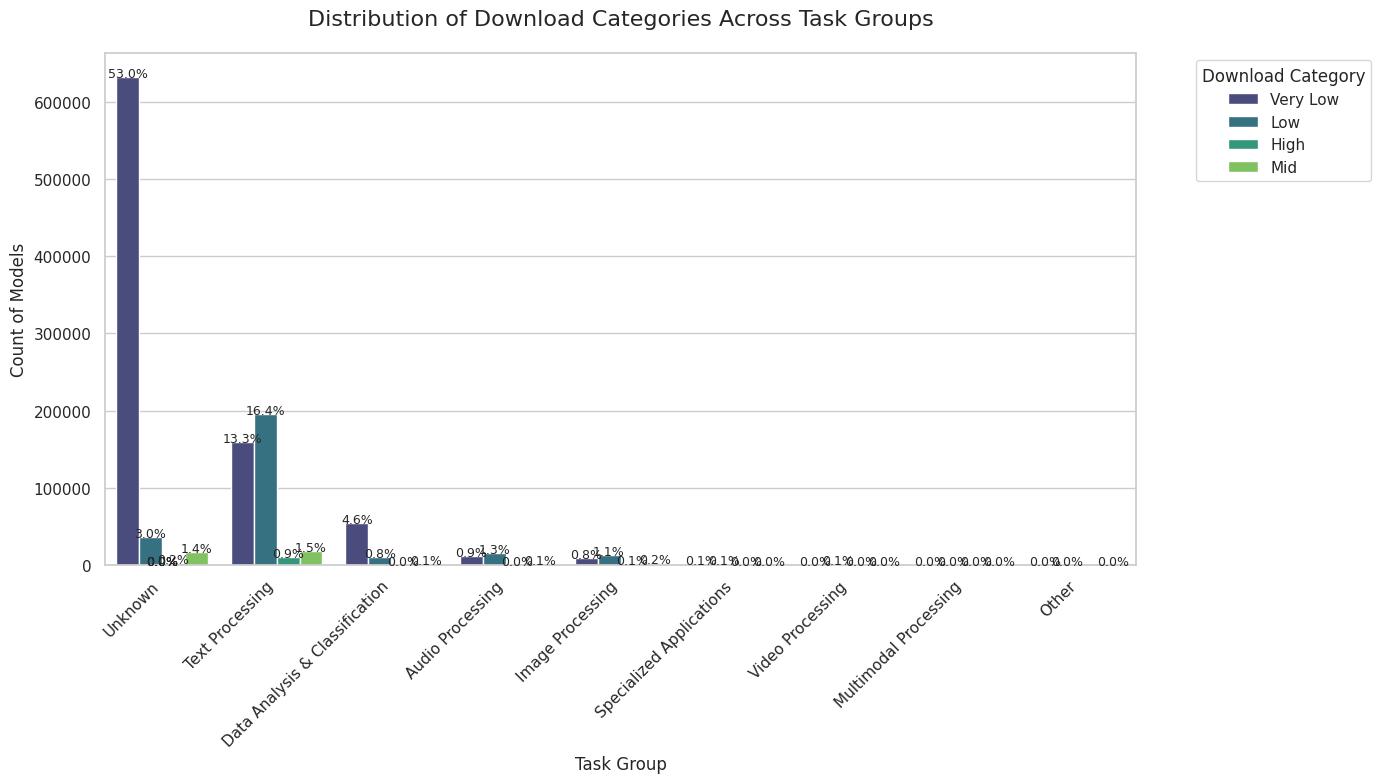

In [6]:
create_distrib(df)

downloads_category
Very Low    867712
Low         867712
High        867712
Mid         867712
Name: count, dtype: int64


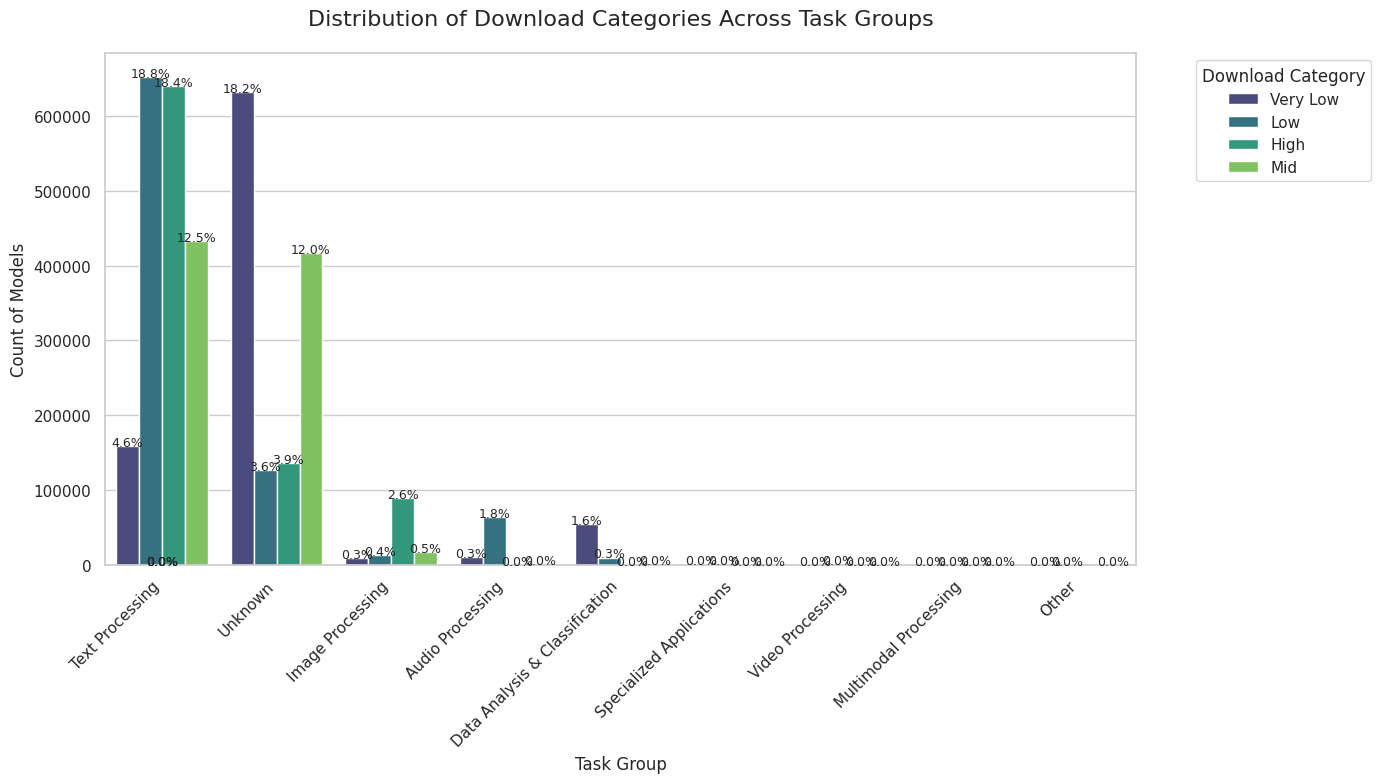

In [15]:
create_distrib(combined_df)

In [16]:
import smote_variants as sv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def preprocess_data(df, features, target):
    """
    Preprocess the data:
     - One-hot encode the features to get numeric columns.
     - Label encode the target if necessary.
     - Return processed X and y.
    """
    # One-hot encode the predictor columns
    X = pd.get_dummies(df[features], drop_first=True)
    
    # Label encode the target column if it's not numeric
    if df[target].dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(df[target])
    else:
        y = df[target].values

    return X, y

# X, y = preprocess_data(df, features, target)
    
# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

# oversampler = sv.MulticlassOversampling(oversampler='', oversampler_params={'random_state': 5})
# X_res, y_res = oversampler.sample(X_train, y_train)

In [20]:
import smote_variants as sv
import sklearn.datasets as datasets

features = ['task_group', 'author_category', 'language_category', 'location']
target = 'downloads_category'

X, y = preprocess_data(df, features, target)

oversampler= sv.MulticlassOversampling(oversampler='kmeans_SMOTE',
                                      oversampler_params={'random_state': 5})

# X_samp and y_samp contain the oversampled dataset
X_samp, y_samp = oversampler.sample(X.astype(int), y)

2025-04-11 12:55:28,007:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2025-04-11 12:55:28,060:INFO:MulticlassOversampling: Sampling minority class with label: 1
2025-04-11 12:55:28,148:INFO:kmeans_SMOTE: Running sampling via ('kmeans_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_clusters': 10, 'irt': 2.0, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 5, 'class_name': 'kmeans_SMOTE'}")


KeyboardInterrupt: 

In [8]:
df = pd.read_csv('utils/oversampled_non_onehot.csv')

downloads_category
Very Low    867712
Low         867712
Mid          37247
High         15166
Name: count, dtype: int64


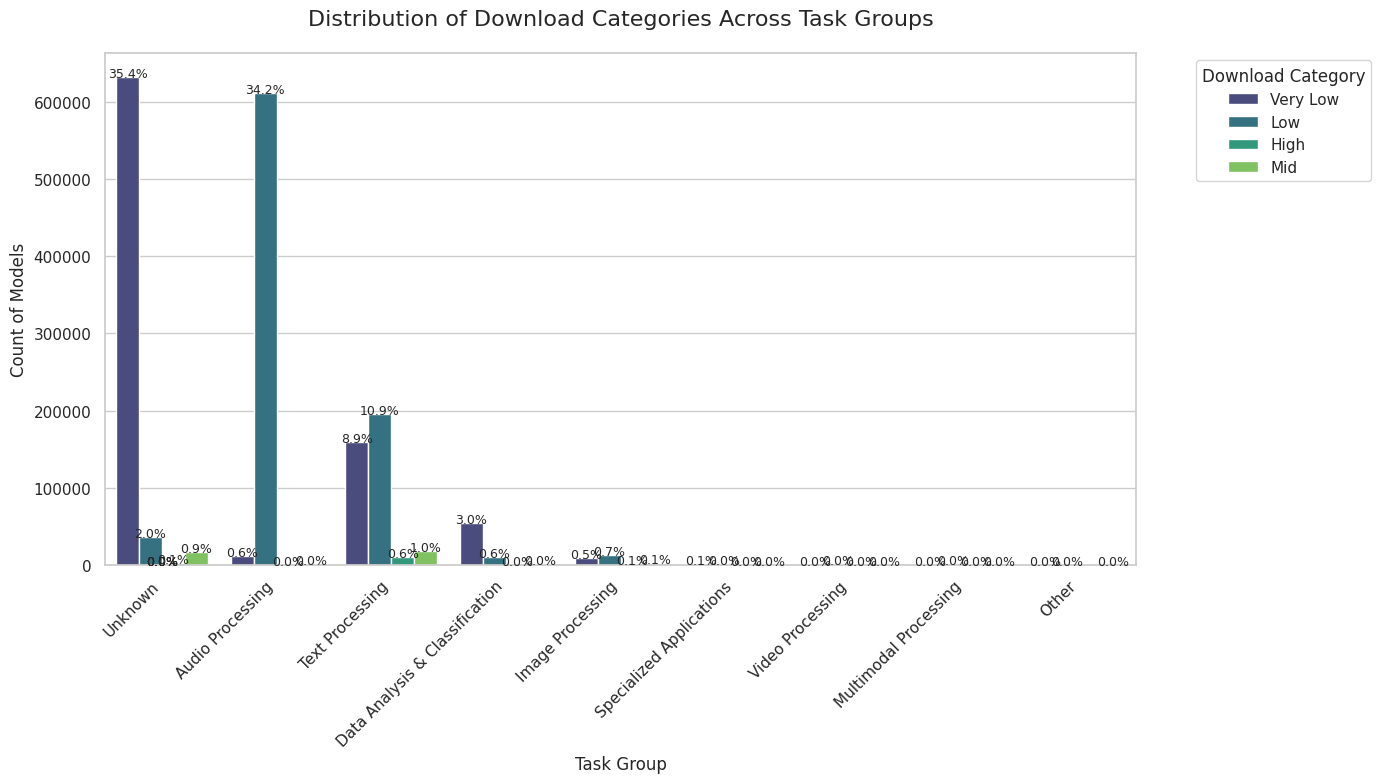

In [9]:
create_distrib(df)

In [ ]:
df = pd.read_csv('utils/oversampled_non_onehot.csv')
df.task_group.value_counts()

task_group
Unknown                           686712
Audio Processing                  623426
Text Processing                   382215
Data Analysis & Classification     65378
Image Processing                   26057
Specialized Applications            1724
Video Processing                    1298
Multimodal Processing               1004
Other                                 23
Name: count, dtype: int64